In [1]:
import pandas as pd
data = pd.read_csv('covid.csv')
data.head()

/var/folders/3l/xh28kn0j7_7d5hh7fgz188940000gn/T/ipykernel_1486/1124783163.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('covid.csv')


,Year,Speed Limit,Time,Age,Crash ID,State,Month,Year1,Time of day,Monday,...,Month_November,Month_October,Month_September,Hour,Period,Period_Night,Period_Morning,Period_Afternoon,Period_Evening,covid
0,1989,100,1900-01-01 16:15:00,66,19891001,NSW,6,2000,Day,0,...,0,0,0,16.0,Afternoon,0,0,1,0,0
1,1989,60,1900-01-01 01:15:00,42,19891002,NSW,8,2000,Night,0,...,0,0,0,1.0,Night,1,0,0,0,0
2,1989,100,1900-01-01 21:15:00,18,19891003,NSW,1,2000,Night,0,...,0,0,0,21.0,Evening,0,0,0,1,0
3,1989,60,1900-01-01 12:30:00,76,19891004,NSW,10,2000,Day,0,...,0,1,0,12.0,Afternoon,0,0,1,0,0
4,1989,100,1900-01-01 07:45:00,15,19891005,NSW,6,2000,Day,0,...,0,0,0,7.0,Morning,0,1,0,0,0


In [2]:
data['Speed Limit'] = pd.to_numeric(data['Speed Limit'], errors='coerce')
data['speed_square'] = data['Speed Limit'] ** 2
def clean_speed_limit(value):
    if isinstance(value, str):
        if '<' in value:
            return int(value.replace('<', ''))
        elif '>' in value:
            return int(value.replace('>', ''))
    try:
        return int(value)
    except ValueError:
        return None

data['Speed Limit'] = data['Speed Limit'].apply(clean_speed_limit)
data['Crash_Type_Single'] = data['Crash Type_Single']
data['Outer_Region_Areas'] = data['Outer_Regional_Areas']
data['Speed_Limit'] = data['Speed Limit']


In [3]:
df = data

Testing Stationarity of Accidents:
Accidents: ADF Statistic = -2.6138, p-value = 0.0902
Optimal lag: 10


/Users/amin/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 21, Feb, 2025
Time:                     12:56:16
--------------------------------------------------------------------
No. of Equations:         15.0000    BIC:                    75.0380
Nobs:                     362.000    HQIC:                   60.3682
Log likelihood:          -14614.4    FPE:                2.32545e+22
AIC:                      50.6883    Det(Omega_mle):     1.24559e+20
--------------------------------------------------------------------
Results for equation Accidents
                            coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------
const                         95.233886        22.210922            4.288           0.000
L1.Accidents                 -36.771981        13.862607           -2.653           0.008
L1.Year             

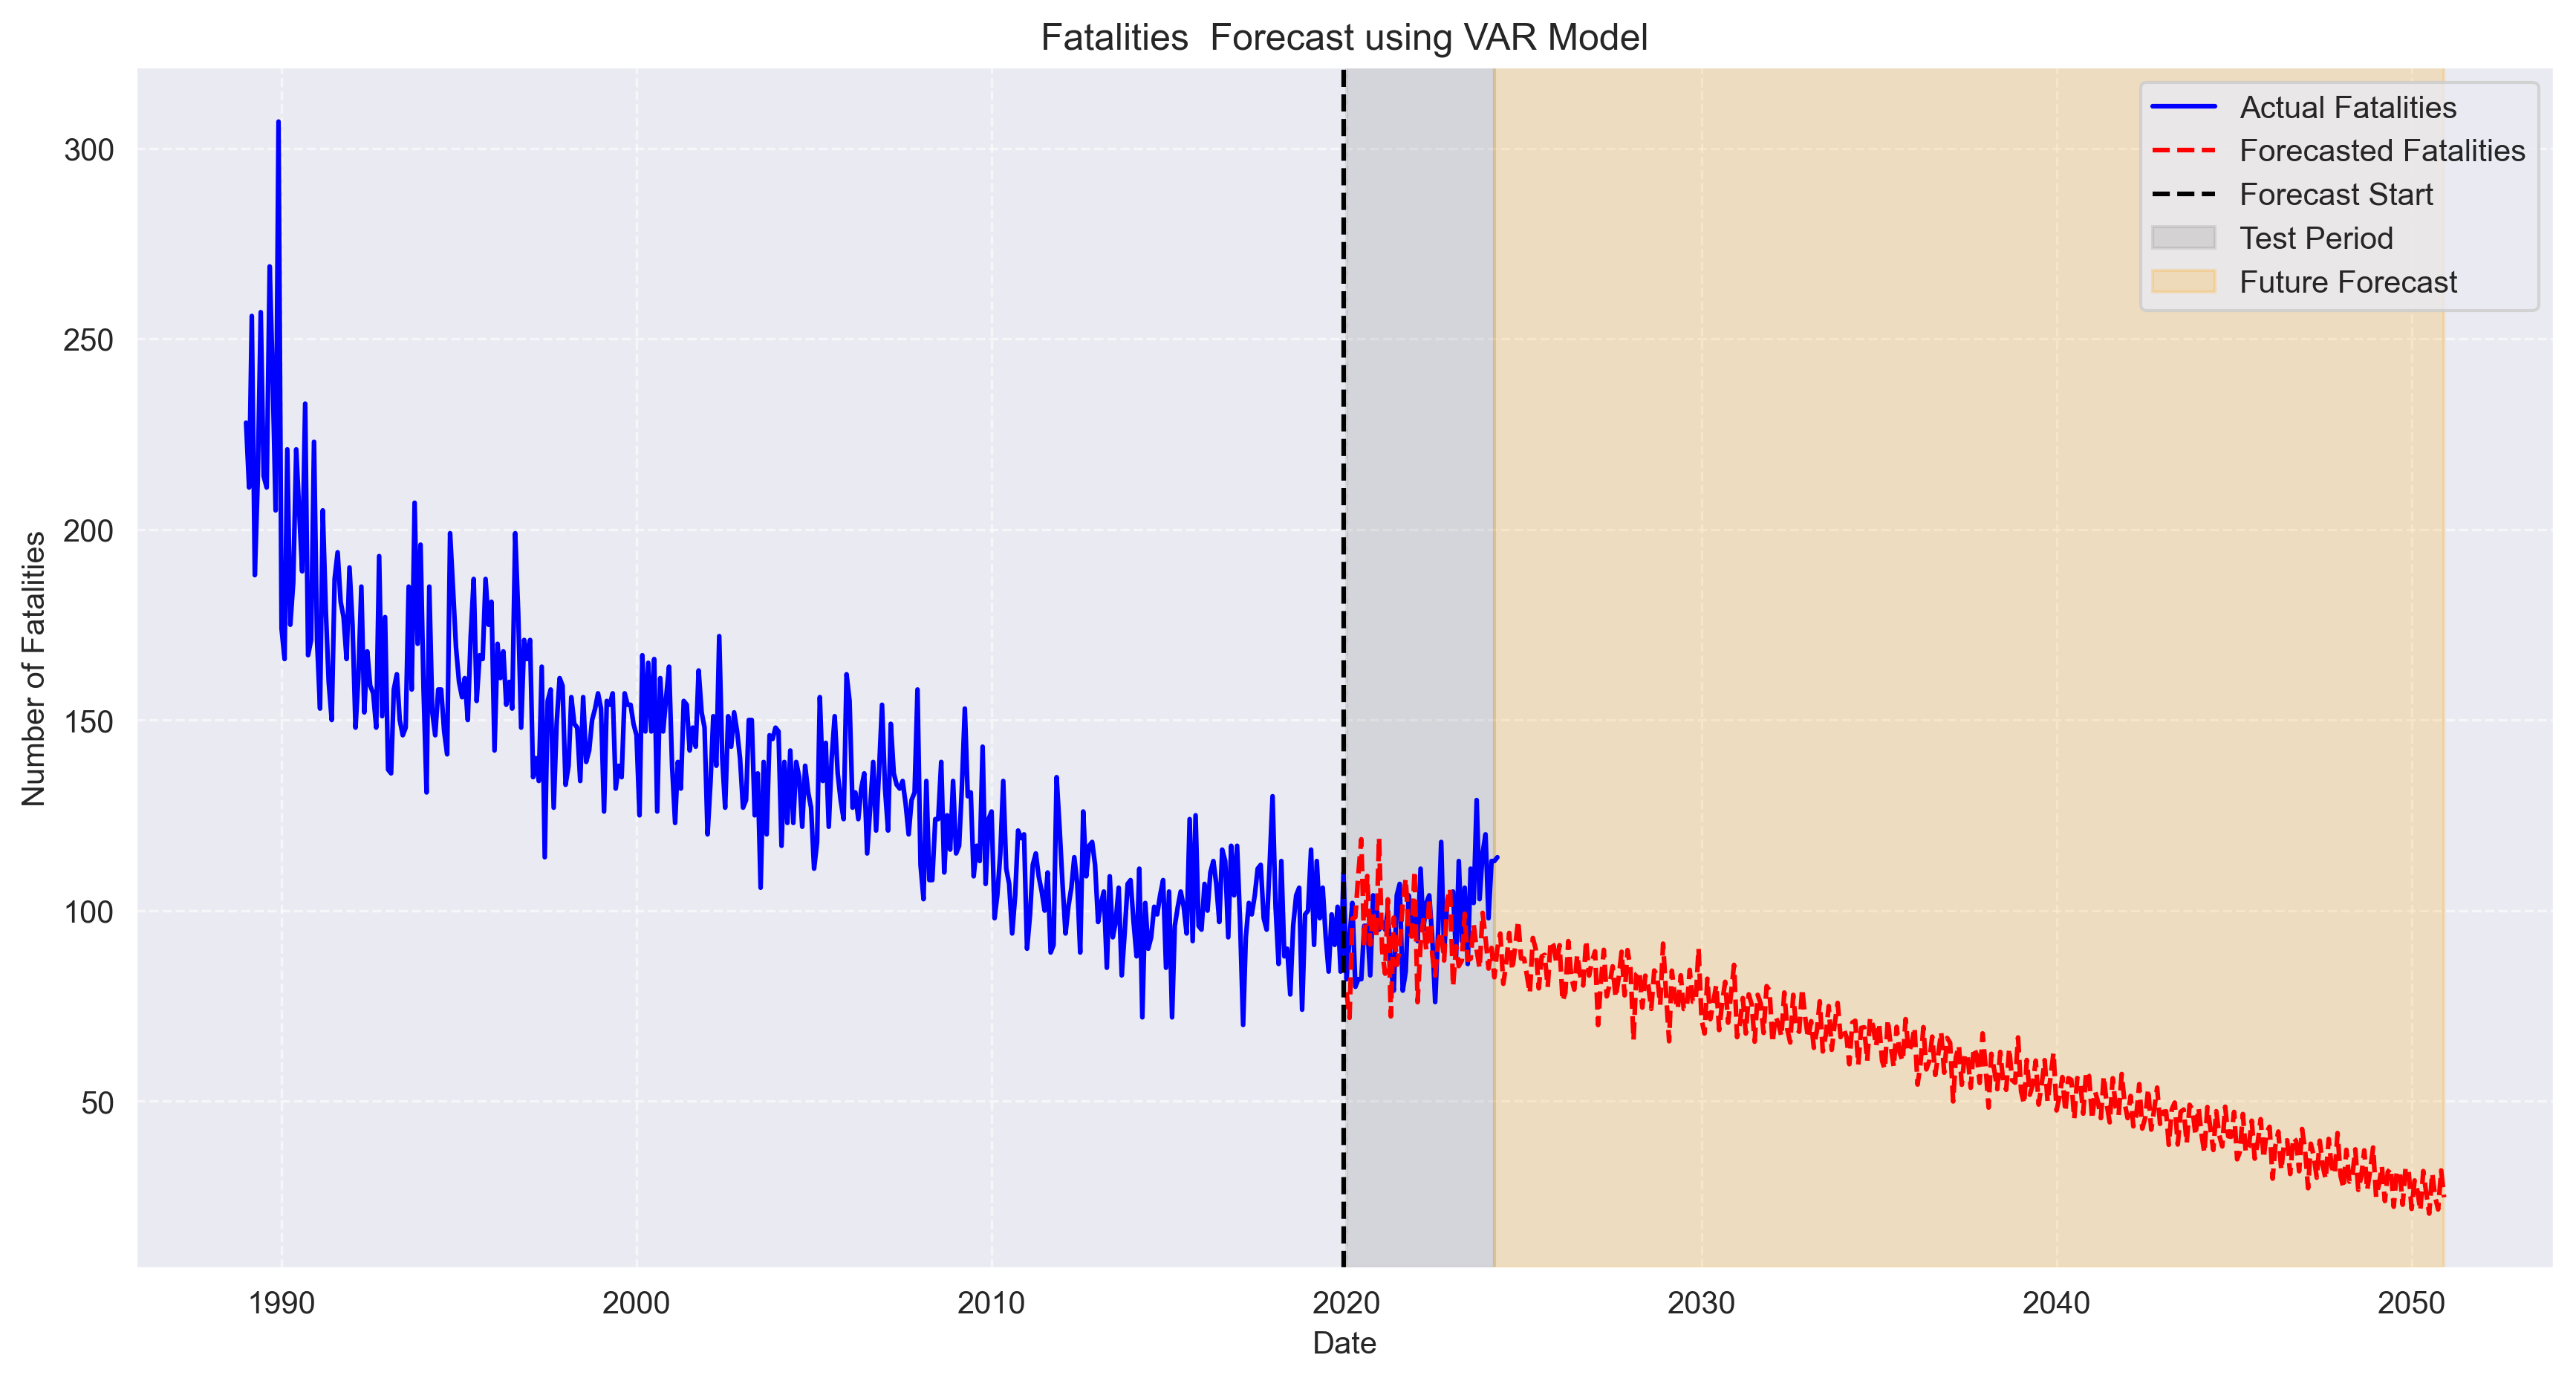

In [4]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

df["Date"] = pd.to_datetime(df["Year"].astype(str) + "-" + df["Month"].astype(str) + "-01")

monthly_accidents = df.groupby("Date").size()

variables = [
    'Year', 'Crash_Type_Single', 'Passenger', 'Pedestrian',
    'Pedal_Cyclist', 'Month_February', 'Month_March',
    'MajorCities_Areas', 'Outer_Region_Areas', 'Remote_Areas',
    'Age26_39', 'Age65_74', 'Age75+', 'Period_Night'
]

monthly_vars = df.groupby("Date")[variables].sum()

var_data = pd.concat([monthly_accidents, monthly_vars], axis=1).dropna()
var_data.rename(columns={0: "Accidents"}, inplace=True)

train_data = var_data[var_data.index.year < 2020]
test_data = var_data[(var_data.index.year >= 2020) & (var_data.index <= "2024-03")]  

def adf_test(series, name):
    result = adfuller(series)
    print(f"{name}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")
    return result[1] < 0.05  

print("Testing Stationarity of Accidents:")
adf_test(train_data["Accidents"], "Accidents")

model = VAR(train_data)
lag_selection = model.select_order(maxlags=10)
optimal_lag = lag_selection.aic
print(f"Optimal lag: {optimal_lag}")

var_model = model.fit(optimal_lag)
print(var_model.summary())

forecast_steps_test = len(test_data)
forecast_steps_future = (2050 - var_data.index[-1].year) * 12
forecast_steps_total = (2050 - train_data.index[-1].year) * 12
forecast = var_model.forecast(train_data.values[-optimal_lag:], steps=forecast_steps_total)
forecast_index = pd.date_range(start=train_data.index[-1], periods=forecast_steps_total+1, freq='MS')[1:]

forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=var_data.columns)

y_true = test_data["Accidents"].values
y_pred = forecast_df.loc[test_data.index, "Accidents"].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"Evaluation Metrics:")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R^2: {r2:.4f}")

#import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7), dpi=300)  # Set the figure size and dpi for high resolution
plt.plot(var_data.index, var_data["Accidents"], label="Actual Fatalities", color='blue')
plt.plot(forecast_df.index, forecast_df["Accidents"], label="Forecasted Fatalities", linestyle='dashed', color='red')
plt.axvline(x=train_data.index[-1], color='black', linestyle='--', label='Forecast Start')
plt.axvspan(test_data.index[0], test_data.index[-1], color='gray', alpha=0.2, label='Test Period')
plt.axvspan(test_data.index[-1], forecast_df.index[-1], color='orange', alpha=0.2, label='Future Forecast')
plt.legend(loc='upper right')  # Move legend to the upper right corner
plt.title("Fatalities  Forecast using VAR Model")
plt.xlabel("Date")
plt.ylabel("Number of Fatalities")
plt.grid(True, linestyle='--', alpha=0.6)

plt.gcf().set_facecolor('white')

# Save with high quality for printing, ensuring no transparency
plt.savefig("accidents_forecast_high_quality500dpi.png", format='png', dpi=500, bbox_inches='tight', facecolor='white', transparent=False)

plt.show()

In [6]:
import openpyxl

# ایجاد یک فایل اکسل و نوشتن داده‌ها در آن
with pd.ExcelWriter("VAR_Model_Output.xlsx", engine="openpyxl") as writer:
    forecast_df.to_excel(writer, sheet_name="Forecast")
    test_data["Accidents"].to_excel(writer, sheet_name="Test_Data")
    
    # ذخیره پیش‌بینی‌های تست به همراه مقدار واقعی
    evaluation_df = pd.DataFrame({
        "Actual": y_true,
        "Predicted": y_pred
    }, index=test_data.index)
    evaluation_df.to_excel(writer, sheet_name="Test_Predictions")

    # ذخیره معیارهای ارزیابی مدل
    metrics_df = pd.DataFrame({
        "Metric": ["MAE", "MSE", "RMSE", "MAPE", "R^2"],
        "Value": [mae, mse, rmse, mape, r2]
    })
    metrics_df.to_excel(writer, sheet_name="Evaluation_Metrics", index=False)

print("نتایج با موفقیت در فایل 'VAR_Model_Output.xlsx' ذخیره شد!")

نتایج با موفقیت در فایل 'VAR_Model_Output.xlsx' ذخیره شد!


In [5]:
forecast_2050 = forecast_df.loc["2050", "Accidents"]
print(forecast_2050)


2050-01-01    21.729966
2050-02-01    29.195991
2050-03-01    26.586670
2050-04-01    21.301624
2050-05-01    31.659820
2050-06-01    25.811963
2050-07-01    20.502034
2050-08-01    31.124367
2050-09-01    24.764439
2050-10-01    21.593540
2050-11-01    31.828895
2050-12-01    24.782687
Freq: MS, Name: Accidents, dtype: float64


In [12]:
actual_2020 = var_data.loc["2020", "Accidents"].sum()
print(f"Actual Accidents in 2020: {actual_2020:.2f}")

Actual Accidents in 2020: 1097.00


In [13]:
forecast_2020 = forecast_df.loc["2020", "Accidents"].sum()
print(f"Predicted Accidents in 2020: {forecast_2020:.2f}")

Predicted Accidents in 2020: 1176.97


In [14]:
actual_2020 = var_data.loc["2021", "Accidents"].sum()
print(f"Actual Accidents in 2021: {actual_2020:.2f}")

Actual Accidents in 2021: 1130.00


In [15]:
forecast_2020 = forecast_df.loc["2021", "Accidents"].sum()
print(f"Predicted Accidents in 2021: {forecast_2020:.2f}")

Predicted Accidents in 2021: 1130.38


In [16]:
actual_2020 = var_data.loc["2022", "Accidents"].sum()
print(f"Actual Accidents in 2022: {actual_2020:.2f}")

Actual Accidents in 2022: 1180.00


In [17]:
forecast_2020 = forecast_df.loc["2022", "Accidents"].sum()
print(f"Predicted Accidents in 2022: {forecast_2020:.2f}")

Predicted Accidents in 2022: 1110.61


In [20]:
actual_2020 = var_data.loc["2023", "Accidents"].sum()
print(f"Actual Accidents in 2023: {actual_2020:.2f}")

Actual Accidents in 2023: 1270.00


In [21]:
forecast_2020 = forecast_df.loc["2023", "Accidents"].sum()
print(f"Predicted Accidents in 2023: {forecast_2020:.2f}")

Predicted Accidents in 2023: 1079.79


In [28]:
forecast_2020 = forecast_df.loc["2050", "Accidents"].sum()
print(f"Predicted Accidents in 2030: {forecast_2020:.2f}")

Predicted Accidents in 2030: 310.88
